# CS 439 Final Project: Crime Rate Prediction

**Contributers:** \
Jenya Pandu (jp2068) - section 03 \
Matt Yun (yy656) - section 03 \
Vivian Zhao (vz57) - section 03 \
**Course:** Introduction to Data Science (01:198:439) \
**Professor:** Naina Chaturvedi \
**Semester:** Spring 2025 

### Import necessary libraries:

In [1]:
# import & setup
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score

### Load and inspect data:

In [2]:
df = pd.read_csv("Chicago-Crime-Data.csv", low_memory=False)
print(df.shape)

(335412, 22)


In [3]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,49.0,1.0,08A,NaN,NaN,2007.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,36.0,19.0,01A,1141387.0,1913179.0,2021.0,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,50.0,13.0,01A,1152781.0,1941458.0,2021.0,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,5.0,05,1162518.0,1925906.0,2023.0,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,6.0,44.0,08B,1183071.0,1847869.0,2023.0,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335412 entries, 0 to 335411
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    335412 non-null  int64  
 1   Case Number           335412 non-null  object 
 2   Date                  335412 non-null  object 
 3   Block                 335411 non-null  object 
 4   IUCR                  335411 non-null  object 
 5   Primary Type          335411 non-null  object 
 6   Description           335411 non-null  object 
 7   Location Description  333781 non-null  object 
 8   Arrest                335411 non-null  object 
 9   Domestic              335411 non-null  object 
 10  Beat                  335411 non-null  float64
 11  District              335411 non-null  float64
 12  Ward                  205431 non-null  float64
 13  Community Area        205983 non-null  float64
 14  FBI Code              335411 non-null  object 
 15  

### Data Cleaning: 

In [5]:
def preprocess(data):
    df = data.copy()
    df = df.drop_duplicates().dropna().reset_index(drop=True)

    # remove unnecessary cols
    df = df.drop(columns=['ID', 'Case Number', 'Year', 
                          'Block', 'IUCR', 'Description', 'Updated On', 'FBI Code',
                          'X Coordinate', 'Y Coordinate', 'Location'])

    # convert data types
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

    for col in ['Arrest', 'Domestic']:
        df[col] = (df[col].astype('bool'))

    for col in ['Beat', 'District', 'Ward', 'Community Area']:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    for col in ['Primary Type', 'Location Description']:
        df[col] = df[col].astype('category')
    
    return df

clean_df = preprocess(df)
display(clean_df)

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude
0,2021-05-24 15:06:00,HOMICIDE,STREET,True,False,2515,25,36,19,41.917838,-87.755969
1,2021-06-26 09:24:00,HOMICIDE,PARKING LOT,True,False,1711,17,50,13,41.995219,-87.713355
2,2023-11-09 07:30:00,BURGLARY,APARTMENT,False,False,1922,19,47,5,41.952345,-87.677975
3,2023-11-12 07:59:00,BATTERY,SMALL RETAIL STORE,True,False,632,6,6,44,41.737751,-87.604856
4,2023-09-06 17:00:00,CRIMINAL DAMAGE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1,42,32,41.886018,-87.633938
...,...,...,...,...,...,...,...,...,...,...,...
199417,2016-01-06 05:27:00,HOMICIDE,STREET,False,False,933,9,3,61,41.808213,-87.660094
199418,2005-11-04 22:30:00,HOMICIDE,STREET,True,False,1131,11,24,26,41.871020,-87.736472
199419,2012-11-30 23:50:00,HOMICIDE,STREET,True,False,2033,20,48,3,41.974165,-87.657757
199420,2001-07-22 17:00:00,MOTOR VEHICLE THEFT,PARKING LOT/GARAGE(NON.RESID.),False,False,825,8,15,66,41.782590,-87.683589


In [6]:
def feature_extract(data):
    df = data.copy()
    
    df['Year']      = df['Date'].dt.year
    df['Month']     = df['Date'].dt.month
    df['Day']       = df['Date'].dt.day
    df['Hour']      = df['Date'].dt.hour
    df['Weekday']   = df['Date'].dt.day_name()

    # define daytime vs. nighttime:
    #    daytime: 6am - 5pm
    #    nighttime: 6pm - 5am
    df['Is_Daytime'] = ((df['Hour'] >= 6) & (df['Hour'] < 18)).astype(int)

    return df

clean_df = feature_extract(clean_df)
display(clean_df)

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Year,Month,Day,Hour,Weekday,Is_Daytime
0,2021-05-24 15:06:00,HOMICIDE,STREET,True,False,2515,25,36,19,41.917838,-87.755969,2021,5,24,15,Monday,1
1,2021-06-26 09:24:00,HOMICIDE,PARKING LOT,True,False,1711,17,50,13,41.995219,-87.713355,2021,6,26,9,Saturday,1
2,2023-11-09 07:30:00,BURGLARY,APARTMENT,False,False,1922,19,47,5,41.952345,-87.677975,2023,11,9,7,Thursday,1
3,2023-11-12 07:59:00,BATTERY,SMALL RETAIL STORE,True,False,632,6,6,44,41.737751,-87.604856,2023,11,12,7,Sunday,1
4,2023-09-06 17:00:00,CRIMINAL DAMAGE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1,42,32,41.886018,-87.633938,2023,9,6,17,Wednesday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199417,2016-01-06 05:27:00,HOMICIDE,STREET,False,False,933,9,3,61,41.808213,-87.660094,2016,1,6,5,Wednesday,0
199418,2005-11-04 22:30:00,HOMICIDE,STREET,True,False,1131,11,24,26,41.871020,-87.736472,2005,11,4,22,Friday,0
199419,2012-11-30 23:50:00,HOMICIDE,STREET,True,False,2033,20,48,3,41.974165,-87.657757,2012,11,30,23,Friday,0
199420,2001-07-22 17:00:00,MOTOR VEHICLE THEFT,PARKING LOT/GARAGE(NON.RESID.),False,False,825,8,15,66,41.782590,-87.683589,2001,7,22,17,Sunday,1


### Exploratory Data Analysis:

In [7]:
violent_types = ['HOMICIDE','ASSAULT','BATTERY','ROBBERY','CRIMINAL SEXUAL ASSAULT','KIDNAPPING']
property_types = ['BURGLARY','THEFT','MOTOR VEHICLE THEFT','ARSON']

agg = (
    clean_df
    .groupby(['District', 'Weekday', 'Is_Daytime'])
    .agg(
        total_crimes    = ('Date', 'size'),
        violent_crimes  = ('Primary Type', lambda x: x.isin(violent_types).sum()),
        property_crimes = ('Primary Type', lambda x: x.isin(property_types).sum()),
        arrest_rate     = ('Arrest', 'mean'),
        domestic_rate   = ('Domestic', 'mean')
    )
    .reset_index()
)

agg['Risk_Rating'] = (
    pd.qcut(agg['total_crimes'], 10, labels=False, duplicates='drop')
      .add(1)  # make values go from 1–10
      .astype(int)
)

X = agg[
    ['District', 'Weekday', 'Is_Daytime',
     'violent_crimes', 'property_crimes', 'arrest_rate', 'domestic_rate']
]
y = agg['Risk_Rating']


# one-hot encode District & Weekday (Is_Daytime already 0/1)
X = pd.get_dummies(X, columns=['District', 'Weekday'], drop_first=True)


### Model Building:

In [8]:
# split & train data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=42)

### Data Visualization:

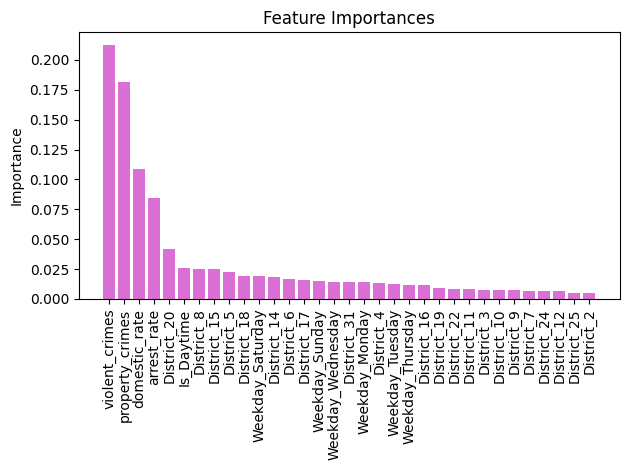

In [9]:
# bar chart: importance of each feature in Random Forest
#    higher importance = model relied on it more in deciding node splits
#    lower importance = model relied on it for fewer splits 

importances = rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure()
plt.bar(range(len(importances)), importances[indices], color='orchid')
plt.title('Feature Importances')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# heatmap: total crimes by District vs. Weekday for daytime and nighttime

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for flag, label in [(1, 'Daytime'), (0, 'Nighttime')]:
    pivot = (
        agg[agg['Is_Daytime'] == flag]
        .pivot_table(index='District',
                     columns='Weekday',
                     values='total_crimes',
                     aggfunc='sum')
        .reindex(columns=weekdays)
    )
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(pivot, aspect='auto', cmap='YlOrRd')
    plt.title(f'Total Crimes by District & Weekday ({label})')
    plt.xlabel('Weekday')
    plt.ylabel('District')
    plt.xticks(np.arange(len(weekdays)), weekdays, rotation=45)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.colorbar(im, label='Total Crimes')
    plt.tight_layout()
    plt.show()

### Evalution:

In [15]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae) 
print("R^2 Score:", r2) 

Mean Absolute Error (MAE): 0.5873015873015873
R^2 Score: 0.9169206423631462
